In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Read the Ethereum price data from the CSV file
eth_data = pd.read_csv('eth-usd-max.csv')
# Convert the 'Date' column to a datetime object if needed
eth_data['Date'] = pd.to_datetime(eth_data['Date'])

# Extract the date part only
eth_data['Date'] = eth_data['Date'].dt.strftime('%Y-%m-%d')

eth_data['Date'] = eth_data['Date'].astype(str).str.replace('-', '/')

# Sort the data by date in ascending order
eth_data = eth_data.sort_values('Date')

# Calculate the daily returns
eth_data['Return'] = np.log(eth_data['price']) - np.log(eth_data['price'].shift(1))


/Users/liyuxuan/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
eth_data

,Date,price,market_cap,total_volume,Return
0,2015/08/07,2.831620,0.000000e+00,9.062200e+04,NaN
1,2015/08/08,1.330750,8.033948e+07,3.680700e+05,-0.755106
2,2015/08/10,0.687586,4.155631e+07,4.004641e+05,-0.660311
3,2015/08/11,1.067379,6.453901e+07,1.518998e+06,0.439775
4,2015/08/12,1.256613,7.601326e+07,2.073893e+06,0.163214
...,...,...,...,...,...
2893,2023/07/10,1864.579471,2.240880e+11,1.979559e+10,-0.000155
2894,2023/07/11,1880.242473,2.259740e+11,8.391364e+09,0.008365
2895,2023/07/12,1878.233708,2.258320e+11,5.375019e+09,-0.001069
2896,2023/07/13,1873.506815,2.250810e+11,7.979716e+09,-0.002520


In [3]:
# Read the CSV files for each bond yield
yield_1yr_data = pd.read_csv('DGS1.csv')
yield_2yr_data = pd.read_csv('DGS2.csv')
yield_10yr_data = pd.read_csv('DGS10.csv')

# Merge the datasets on the 'Date' column, ensuring that dates align correctly
merged_data = yield_1yr_data.merge(yield_2yr_data, on='Date', how='inner')
merged_data = merged_data.merge(yield_10yr_data, on='Date', how='inner')

In [4]:
#2018/7/13 to 2018/07/13 so can inner join
# Convert the 'Date' column to a string
merged_data['Date'] = merged_data['Date'].astype(str)

# Split the date into year, month, and day components
merged_data[['Year', 'Month', 'Day']] = merged_data['Date'].str.split('/', expand=True)

# Pad the month and day values with leading zeros
merged_data['Month'] = merged_data['Month'].str.zfill(2)
merged_data['Day'] = merged_data['Day'].str.zfill(2)

# Combine the components back into the desired format
merged_data['Date'] = merged_data['Year'] + '/' + merged_data['Month'] + '/' + merged_data['Day']

# Drop the intermediate columns
merged_data = merged_data.drop(columns=['Year', 'Month', 'Day'])

#merged with eth_data
merged_data = merged_data.merge(eth_data, on='Date', how='inner')



In [5]:
merged_data['DGS1'] = merged_data['DGS1'].replace('.', np.nan)
merged_data['DGS2'] = merged_data['DGS2'].replace('.', np.nan)
merged_data['DGS10'] = merged_data['DGS10'].replace('.', np.nan)
merged_data.dropna(subset=['DGS1', 'DGS2', 'DGS10'], inplace=True)

In [6]:
merged_data

,Date,DGS1,DGS2,DGS10,price,market_cap,total_volume,Return
0,2018/07/13,2.37,2.59,2.83,427.792244,4.305858e+10,1.431812e+09,-0.034990
1,2018/07/16,2.39,2.59,2.85,446.609521,4.498001e+10,1.144805e+09,0.033758
2,2018/07/17,2.39,2.62,2.86,478.208507,4.817224e+10,2.202047e+09,0.068362
3,2018/07/18,2.43,2.6,2.88,497.177546,5.009338e+10,1.948063e+09,0.038900
4,2018/07/19,2.4,2.6,2.84,475.990158,4.796830e+10,1.914259e+09,-0.043550
...,...,...,...,...,...,...,...,...
1300,2023/07/07,5.41,4.94,4.06,1855.474784,2.234120e+11,1.354406e+10,-0.029227
1301,2023/07/10,5.38,4.85,4.01,1864.579471,2.240880e+11,1.979559e+10,-0.000155
1302,2023/07/11,5.44,4.88,3.99,1880.242473,2.259740e+11,8.391364e+09,0.008365
1303,2023/07/12,5.35,4.72,3.86,1878.233708,2.258320e+11,5.375019e+09,-0.001069


In [7]:
merged_data.to_csv("bizzao_capital.csv", index=False)

In [8]:
merged_data[['DGS1', 'DGS2', 'DGS10']] = merged_data[['DGS1', 'DGS2', 'DGS10']].apply(pd.to_numeric)


X = sm.add_constant(merged_data[['DGS1', 'DGS2', 'DGS10']])
y = merged_data['Return']

model = sm.OLS(y, X)
results = model.fit()


In [9]:
# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     3.037
Date:                Mon, 17 Jul 2023   Prob (F-statistic):             0.0282
Time:                        11:55:35   Log-Likelihood:                 1955.3
No. Observations:                1250   AIC:                            -3903.
Df Residuals:                    1246   BIC:                            -3882.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.006      0.776      0.4

# 1 year US treasury bond

In [28]:
X = sm.add_constant(merged_data[['DGS1']])
y = merged_data['Return']

model = sm.OLS(y, X)
results = model.fit()
# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.372
Date:                Mon, 17 Jul 2023   Prob (F-statistic):             0.0665
Time:                        12:57:55   Log-Likelihood:                 1952.4
No. Observations:                1250   AIC:                            -3901.
Df Residuals:                    1248   BIC:                            -3891.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.002      1.056      0.2

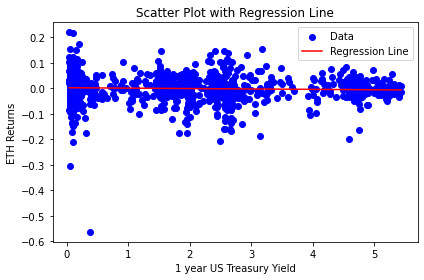

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the independent variable (US Treasury yield) and dependent variable (ETH returns)
x = merged_data['DGS1']
y = merged_data['Return']

# Fit a polynomial regression line
coefs = np.polyfit(x, y, deg=1)
poly_func = np.poly1d(coefs)
line_x = np.linspace(min(x), max(x), 100)
line_y = poly_func(line_x)

# Create the scatter plot and regression line
fig, ax = plt.subplots()
ax.scatter(x, y, color='blue', label='Data')
ax.plot(line_x, line_y, color='red', label='Regression Line')

# Add labels and title
ax.set_xlabel('1 year US Treasury Yield')
ax.set_ylabel('ETH Returns')
ax.set_title('Scatter Plot with Regression Line')

# Add legend
ax.legend()

# Adjust the plot layout
plt.tight_layout()

# Display the plot
plt.show()


# 2 year US treasury bond

In [32]:
X = sm.add_constant(merged_data[['DGS2']])
y = merged_data['Return']

model = sm.OLS(y, X)
results = model.fit()
# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     4.737
Date:                Mon, 17 Jul 2023   Prob (F-statistic):             0.0297
Time:                        12:59:49   Log-Likelihood:                 1953.1
No. Observations:                1250   AIC:                            -3902.
Df Residuals:                    1248   BIC:                            -3892.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.002      1.398      0.1

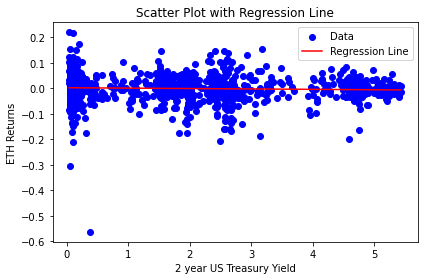

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the independent variable (US Treasury yield) and dependent variable (ETH returns)
x = merged_data['DGS1']
y = merged_data['Return']

# Fit a polynomial regression line
coefs = np.polyfit(x, y, deg=1)
poly_func = np.poly1d(coefs)
line_x = np.linspace(min(x), max(x), 100)
line_y = poly_func(line_x)

# Create the scatter plot and regression line
fig, ax = plt.subplots()
ax.scatter(x, y, color='blue', label='Data')
ax.plot(line_x, line_y, color='red', label='Regression Line')

# Add labels and title
ax.set_xlabel('2 year US Treasury Yield')
ax.set_ylabel('ETH Returns')
ax.set_title('Scatter Plot with Regression Line')

# Add legend
ax.legend()

# Adjust the plot layout
plt.tight_layout()

# Display the plot
plt.show()


# Regression with 10 year US treasury bond

In [34]:
X = sm.add_constant(merged_data[['DGS10']])
y = merged_data['Return']

model = sm.OLS(y, X)
results = model.fit()
# Print the regression results
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     5.279
Date:                Mon, 17 Jul 2023   Prob (F-statistic):             0.0217
Time:                        12:59:59   Log-Likelihood:                 1953.4
No. Observations:                1250   AIC:                            -3903.
Df Residuals:                    1248   BIC:                            -3892.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0064      0.003      1.888      0.0

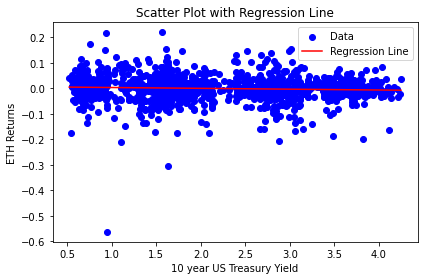

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the independent variable (US Treasury yield) and dependent variable (ETH returns)
x = merged_data['DGS10']
y = merged_data['Return']

# Fit a polynomial regression line
coefs = np.polyfit(x, y, deg=1)
poly_func = np.poly1d(coefs)
line_x = np.linspace(min(x), max(x), 100)
line_y = poly_func(line_x)

# Create the scatter plot and regression line
fig, ax = plt.subplots()
ax.scatter(x, y, color='blue', label='Data')
ax.plot(line_x, line_y, color='red', label='Regression Line')

# Add labels and title
ax.set_xlabel('10 year US Treasury Yield')
ax.set_ylabel('ETH Returns')
ax.set_title('Scatter Plot with Regression Line')

# Add legend
ax.legend()

# Adjust the plot layout
plt.tight_layout()

# Display the plot
plt.show()


# correlation test

In [13]:
import pandas as pd

# Prepare the data
eth_returns = merged_data['Return']
treasury_yields = merged_data['DGS1']

# Calculate the correlation coefficient
correlation_coefficient = eth_returns.corr(treasury_yields)

# Print the correlation coefficient
print("Correlation Coefficient:", correlation_coefficient)

Correlation Coefficient: -0.05191189007997178


In [14]:
import pandas as pd

# Prepare the data
eth_returns = merged_data['Return']
treasury_yields = merged_data['DGS2']

# Calculate the correlation coefficient
correlation_coefficient = eth_returns.corr(treasury_yields)

# Print the correlation coefficient
print("Correlation Coefficient:", correlation_coefficient)

Correlation Coefficient: -0.061493977173849204


In [15]:
import pandas as pd

# Prepare the data
eth_returns = merged_data['Return']
treasury_yields = merged_data['DGS10']

# Calculate the correlation coefficient
correlation_coefficient = eth_returns.corr(treasury_yields)

# Print the correlation coefficient
print("Correlation Coefficient:", correlation_coefficient)

Correlation Coefficient: -0.06490267607895009


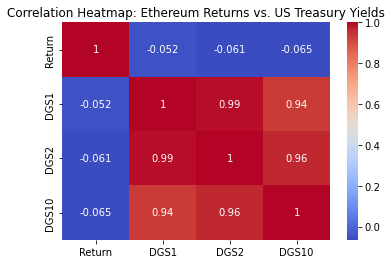

In [41]:
import seaborn as sns

# Select the columns of interest
columns_of_interest = ['Return', 'DGS1', 'DGS2', 'DGS10']

# Create a correlation matrix
correlation_matrix = merged_data[columns_of_interest].corr()

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Add title
plt.title('Correlation Heatmap: Ethereum Returns vs. US Treasury Yields')

# Display the heatmap
plt.show()